## Integrate model inter-cluster with three clustering

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import copy

import os
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from utils import filter_out_isolate, draw_cluster_info, draw_isolate_cluster_info, draw_trainer_info, print_data_info


In [5]:
import sys
import inspect
import torch
from torch_geometric.utils import scatter_

special_args = [
    'edge_index', 'edge_index_i', 'edge_index_j', 'size', 'size_i', 'size_j'
]
__size_error_msg__ = ('All tensors which should get mapped to the same source '
                      'or target nodes must be of same size in dimension 0.')

is_python2 = sys.version_info[0] < 3
getargspec = inspect.getargspec if is_python2 else inspect.getfullargspec


class MessagePassing(torch.nn.Module):
    r"""Base class for creating message passing layers

    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{i,j}\right) \right),

    where :math:`\square` denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean or max, and :math:`\gamma_{\mathbf{\Theta}}`
    and :math:`\phi_{\mathbf{\Theta}}` denote differentiable functions such as
    MLPs.
    See `here <https://pytorch-geometric.readthedocs.io/en/latest/notes/
    create_gnn.html>`__ for the accompanying tutorial.

    Args:
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"` or :obj:`"max"`).
            (default: :obj:`"add"`)
        flow (string, optional): The flow direction of message passing
            (:obj:`"source_to_target"` or :obj:`"target_to_source"`).
            (default: :obj:`"source_to_target"`)
    """

    def __init__(self, aggr='add', flow='source_to_target'):
        super(MessagePassing, self).__init__()

        self.aggr = aggr
        assert self.aggr in ['add', 'mean', 'max']

        self.flow = flow
        # give a warning if the option is not valid
        assert self.flow in ['source_to_target', 'target_to_source']

        self.__message_args__ = getargspec(self.message)[0][1:]
        # we will have [x_j, norm ] put into self.__message_args__
        
        self.__special_args__ = [(i, arg)
                                 for i, arg in enumerate(self.__message_args__)
                                 if arg in special_args]
        
        self.__message_args__ = [arg for arg in self.__message_args__ if arg not in special_args]
        
        self.__update_args__ = getargspec(self.update)[0][2:]
        # empty, since there is nothing beyond: agg_out

#     function call: res = self.propagate(edge_index, x=x, norm=norm)
    def propagate(self, edge_index, size=None, **kwargs):
        r"""The initial call to start propagating messages.

        Args:
            edge_index (Tensor): The indices of a general (sparse) assignment
                matrix with shape :obj:`[N, M]` (can be directed or
                undirected).
            size (list or tuple, optional): The size :obj:`[N, M]` of the
                assignment matrix. If set to :obj:`None`, the size is tried to
                get automatically inferred. (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct messages
                and to update node embeddings.
        """
        dim = 0
        size = [None, None] if size is None else list(size)
        assert len(size) == 2

        i, j = (0, 1) if self.flow == 'target_to_source' else (1, 0)
        # here (i, j) == (1, 0)
        ij = {"_i": i, "_j": j}

        message_args = []
        
        for arg in self.__message_args__:
#             arg[-2] == '_j'
            if arg[-2:] in ij.keys():
#                 tmp == x, is inside the dwargs
                tmp = kwargs.get(arg[:-2], None)   # get the value of the parameter
                if tmp is None:  # pragma: no cover
                    message_args.append(tmp)
                else:
                    idx = ij[arg[-2:]]    # idx == 0
                    if isinstance(tmp, tuple) or isinstance(tmp, list):
                        assert len(tmp) == 2
                        if tmp[1 - idx] is not None:
                            if size[1 - idx] is None:
                                size[1 - idx] = tmp[1 - idx].size(dim)
                            if size[1 - idx] != tmp[1 - idx].size(dim):
                                raise ValueError(__size_error_msg__)
                        tmp = tmp[idx]
                    
                    if tmp is None:
                        message_args.append(tmp)
                    else:
                        if size[idx] is None:
                            size[idx] = tmp.size(dim)
                        if size[idx] != tmp.size(dim):
                            raise ValueError(__size_error_msg__)
                        # dim == 0, we duplicate part of the embeddings x by using the edge_index[idx]
#                         print('Inside the propagate, edge_index[idx]: \n', edge_index[idx].shape, '\n', edge_index[idx])
                        tmp = torch.index_select(tmp, dim, edge_index[idx])
                        message_args.append(tmp)   # here we append x from the kwargs
            else:
                message_args.append(kwargs.get(arg, None))   # here we append norm
        
#         message_args are: x_j, norm 
#         size:  [8, None] 
#         kwargs:  dict_keys(['x', 'norm']) 
#         special keys:  []
        
        size[0] = size[1] if size[0] is None else size[0]
        size[1] = size[0] if size[1] is None else size[1]

        kwargs['edge_index'] = edge_index
        kwargs['size'] = size
        
        # for now self.__special_args__ is empty
        for (idx, arg) in self.__special_args__:
            if arg[-2:] in ij.keys():
                # here we will change the content of x (features)
                # features will be corresponds to edge_index
                message_args.insert(idx, kwargs[arg[:-2]][ij[arg[-2:]]])
            else:
                message_args.insert(idx, kwargs[arg])

        update_args = [kwargs[arg] for arg in self.__update_args__]
#         message_args are: x_j, norm 
        out = self.message(*message_args)
        # here i = 1, edge_index is the target endpoint of an edge, size[i] is the size of target endpoints
        out = scatter_(self.aggr, out, edge_index[i], dim_size=size[i])
        out = self.update(out, *update_args)
        return out

    def message(self, x_j):  # pragma: no cover
        r"""Constructs messages in analogy to :math:`\phi_{\mathbf{\Theta}}`
        for each edge in :math:`(i,j) \in \mathcal{E}`.
        Can take any argument which was initially passed to :meth:`propagate`.
        In addition, features can be lifted to the source node :math:`i` and
        target node :math:`j` by appending :obj:`_i` or :obj:`_j` to the
        variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`."""

        return x_j

    def update(self, aggr_out):  # pragma: no cover
        r"""Updates node embeddings in analogy to
        :math:`\gamma_{\mathbf{\Theta}}` for each node
        :math:`i \in \mathcal{V}`.
        Takes in the output of aggregation as first argument and any argument
        which was initially passed to :meth:`propagate`."""

        return aggr_out


In [6]:
import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops

### ================== Definition of custom GCN

def glorot(tensor):
    if tensor is not None:
        # stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        # tensor.data.uniform_(-stdv, stdv)
        tensor.data.fill_(1.0)   # trivial example
        
def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

class custom_GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, improved=False, cached=False,
                 bias=True, **kwargs):
        super().__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)
        self.cached_result = None
        self.cached_num_edges = None


    @staticmethod
    def norm(edge_index, num_nodes, edge_weight=None, improved=False, dtype=None):
        
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
        
        fill_value = 1 if not improved else 2
        
        edge_index, edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)
        
        row, col = edge_index   
        # row includes the starting points of the edges  (first row of edge_index)
        # col includes the ending points of the edges   (second row of edge_index)

        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # row records the source nodes, which is the index we are trying to add
        # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops
        
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        
#         print('whole GCN training normalized_edge_weight: \n', normalized_edge_weight)
        return edge_index, normalized_edge_weight

    def forward(self, x, edge_index, edge_weight = None):
        """"""
#         print('current weight is: ')
#         print(self.weight)
#         print('current bias is: ')
#         print(self.bias)
        
        x = torch.matmul(x, self.weight)   # update x (embeddings)
        
#         print('inside custom_GCN, edge_index: ', edge_index.shape, '\n', edge_index)
        res = self.propagate(edge_index, x = x, norm = edge_weight)
        return res

    # self is the first parameter of the message func
    def message(self, x_j, norm):
        # in source code of the MessagePassing:
#         self.__message_args__ = getargspec(self.message)[0][1:]  : will be initialized as [x_j, norm]
        
        # view is to reshape the tensor, here make it only a single column
        # use the normalized weights multiplied by the feature of the target nodes
        '''
        For each of extended edge_index:(x_i, x_j), assume there is N such edges
        x_j of shape (N, k) , assume there is k features, value along each row are the same
        norm of shape (1, m), assume there is m edges (including self loops), 1-D tensor
        '''
#         print('inside the message custom_GCN: norm \n', norm.shape, '\n', norm)
#         print('inside the message custom_GCN: x_j \n', x_j.shape, '\n', x_j)
        res = norm.view(-1, 1) * x_j  # use the element wise multiplication
        return res

    def update(self, aggr_out):
        # update the embeddings of each node
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)



In [7]:
### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        # one trivial example
#         self.conv1 = custom_GCNConv(in_channels, out_channels)
#         self.conv2 = GCNConv(16, dataset.num_classes)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        for i, _ in enumerate(self.input_layers[:-1]):
            self.layers.append(custom_GCNConv(self.input_layers[i],self.input_layers[i+1]))
        self.layers = ListModule(*self.layers)


    def forward(self, edge_index, features, edge_weights = None):
        if len(self.layers) > 1:
            for i, _ in enumerate(self.input_layers[:-2]):
                features = F.relu(self.layers[i](features, edge_index, edge_weights))
                if i>1:
                    features = F.dropout(features, p = self.dropout, training = self.training)
            features = self.layers[i+1](features, edge_index, edge_weights)
        else:
            features = self.layers[0](features, edge_index, edge_weights)    # for a single layer case

        predictions = F.log_softmax(features, dim=1)
        return predictions

In [8]:

class single_Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(single_Net, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        # here we just initialize the model
        self.conv1 = custom_GCNConv(self.in_channels, self.out_channels)
        

    def forward(self, edge_index, features, edge_weights = None):
        # call the instance of the custom_GCNConv
        z = self.conv1(features, edge_index, edge_weights)    # for a single layer case, z is embeddings
#         print('embeddings inside the net work model, result is: \n', z)
        
        predictions = F.log_softmax(z, dim=1)
#         print('calibration inside the net work model, result is: \n', predictions)
        return predictions

### Partition GCN

#### Partition method

In [9]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, partition_num = 2):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        """
        tmp = edge_index.t().numpy().tolist()
        self.graph = nx.from_edgelist(tmp)
        self.features = features
        self.label = label
        self.partition_num = partition_num
        self._set_sizes()
        self.edge_index = edge_index
        # this will get the edge weights in a complete graph
        self.get_edge_weight(self.edge_index, self.node_count)

    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
        
    def get_edge_weight(self, edge_index, num_nodes, edge_weight=None, improved=False, dtype=None):
        
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
        
        fill_value = 1 if not improved else 2
        # there are num_nodes self-loop edges added after the edge_index
        edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, fill_value, num_nodes)
        
        row, col = edge_index   
        # row includes the starting points of the edges  (first row of edge_index)
        # col includes the ending points of the edges   (second row of edge_index)

        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # row records the source nodes, which is the index we are trying to add
        # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops
        
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        self.edge_index_global_self_loops = edge_index
        # transfer from tensor to the numpy to construct the dict for the edge_weights
        edge_index = edge_index.t().numpy()
        normalized_edge_weight = normalized_edge_weight.numpy()
        num_edge, _ = edge_index.shape
        # this info can also be stored as matrix considering the memory, depends whether the matrix is sparse or not
        self.edge_weight_global_dict = {(edge_index[i][0], edge_index[i][1]) : normalized_edge_weight[i] for i in range(num_edge)}
        
#         print('after adding self-loops, edge_index is', edge_index)
        self.edge_weight_global = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in edge_index ]
#         print('a list of the global weights : \n', self.edge_weight_global )
    
        
    def decompose(self, test_ratio, validation_ratio):
        """
        Decomposing the graph, partitioning the features and label, creating Torch arrays.
        """
        # to keep the edge weights of the original whole graph:
        
        self.metis_clustering()
#         self.random_clustering()
        self._set_inter_clusters()
        self.general_global_isolate_partitioning(test_ratio, validation_ratio)
        # for the wholeGCNTraniner Purpose
        self.general_accumulate_partition()
        
    def _set_inter_clusters(self):
        # independent of the clustering method:
        self.intersect_cluster = []
        for i in range(1, self.partition_num):
            tmp = [(m, n) for m, n in zip(self.clusters, self.clusters[i:])]
            self.intersect_cluster.extend(tmp)
        # initialize as the totla edges (without duplicates) all over the whole graph
        self.macro_inter_edges = set(self.graph.edges())   # a sequence of tuple to indicate edges

    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self):
        """
        Random clustering the nodes.
        """
        self.clusters = [cluster for cluster in range(self.partition_num)]
        # randomly divide into two clusters
        self.cluster_membership = {node: random.choice(self.clusters) for node in self.graph.nodes()}

    def metis_clustering(self):
        """
        Clustering the graph with Metis. For details see:
        """
        (st, parts) = metis.part_graph(self.graph, self.partition_num)
        self.clusters = list(set(parts))
        self.cluster_membership = {node: membership for node, membership in enumerate(parts)}


    def general_global_isolate_partitioning(self, test_ratio, validation_ratio):
        """
        Creating data partitions and train-test splits.
        """
        self.type = 'general'
        relative_test_ratio = (test_ratio) / (1 - validation_ratio)
        self.sg_nodes_global = {}
        self.sg_edges_global = {}
        
        self.sg_model_nodes_global = {}
        self.sg_validation_nodes_global = {}
        self.sg_train_nodes_global = {}
        self.sg_test_nodes_global = {}
        
        # keep the info of each cluster:
        self.info_isolate_cluster_size = {}
        self.info_model_cluster_size = {}
        self.info_validation_cluster_size = {}
        self.info_train_cluster_size = {}
        self.info_test_cluster_size = {}
        
        for cluster in self.clusters:
            
            subgraph = self.graph.subgraph([node for node in sorted(self.graph.nodes()) if self.cluster_membership[node] == cluster])
            
            self.sg_nodes_global[cluster] = sorted(node for node in subgraph.nodes())
            
            self.sg_edges_global[cluster] = {edge for edge in subgraph.edges()}
            # substract two possible directions of edges
            self.macro_inter_edges -= set([(edge[0], edge[1]) for edge in subgraph.edges()] +  \
                                       [(edge[1], edge[0]) for edge in subgraph.edges()])
            
            self.sg_model_nodes_global[cluster], self.sg_validation_nodes_global[cluster] = train_test_split(self.sg_nodes_global[cluster], test_size = validation_ratio)
            self.sg_model_nodes_global[cluster] = sorted(self.sg_model_nodes_global[cluster])
            self.sg_validation_nodes_global[cluster] = sorted(self.sg_validation_nodes_global[cluster])
            
            self.sg_train_nodes_global[cluster], self.sg_test_nodes_global[cluster] = train_test_split(self.sg_model_nodes_global[cluster], test_size = relative_test_ratio)
            self.sg_train_nodes_global[cluster] = sorted(self.sg_train_nodes_global[cluster])
            self.sg_test_nodes_global[cluster] = sorted(self.sg_test_nodes_global[cluster])
            
            # record the information of each cluster:
            self.info_isolate_cluster_size[cluster] = len(self.sg_nodes_global[cluster])
            self.info_model_cluster_size[cluster] = len(self.sg_model_nodes_global[cluster])
            self.info_validation_cluster_size[cluster] = len(self.sg_validation_nodes_global[cluster])
            
            self.info_train_cluster_size[cluster] = len(self.sg_train_nodes_global[cluster])
            self.info_test_cluster_size[cluster] = len(self.sg_test_nodes_global[cluster])
    
    # accumulate all the train, test, and validation nodes 
    def general_accumulate_partition(self):
        # sum up different parts of the data
#         self.total_sg_train_nodes_global = sorted(chain.from_iterable(self.sg_train_nodes_global[cluster] for cluster in self.clusters))
#         self.total_sg_test_nodes_global = sorted(chain.from_iterable(self.sg_test_nodes_global[cluster] for cluster in self.clusters)) 
        self.total_sg_train_nodes_global = sorted(self.sg_train_nodes_global[0])
        self.total_sg_test_nodes_global = sorted(self.sg_test_nodes_global[0])
        self.total_sg_validation_nodes_global = sorted(chain.from_iterable(self.sg_validation_nodes_global[cluster] for cluster in self.clusters))
    
    def general_base_isolate_clustering(self):
        self.type = 'base_isolate'
        self.sg_overlapping_nodes_global = {key : set(val) for key, val in self.sg_nodes_global.items()}
        # global id of edges, each edge is recorded only one time
        self.sg_overlapping_edges_global = copy.deepcopy(self.sg_edges_global)
        
        self.sg_edges_local = {}
        self.sg_edge_weight_local = {}
        self.sg_isolate_nodes_local = {}
        
        self.sg_train_nodes_local = {}
        self.sg_test_nodes_local = {}
        self.sg_validation_nodes_local = {}
        
        self.sg_features = {}
        self.sg_labels = {}
        
        self.info_overlapping_cluster_size = {}
        
        for cluster in self.clusters:
            self.sg_overlapping_nodes_global[cluster] = sorted(self.sg_overlapping_nodes_global[cluster])
            mapper = {node: i for i, node in enumerate(sorted(self.sg_nodes_global[cluster]))}
            self.sg_isolate_nodes_local[cluster] = [mapper[node] for node in self.sg_nodes_global[cluster]]
            sg_node_index_local = sorted(mapper.values())
            # the edges inside its own partition, from two directions since it is an undirected graph
            self.sg_edges_local[cluster] = [ [mapper[edge[0]], mapper[edge[1]]] for edge in self.sg_edges_global[cluster] ] + \
                                           [ [mapper[edge[1]], mapper[edge[0]]] for edge in self.sg_edges_global[cluster] ] + \
                                           [ [i, i] for i in sg_node_index_local ]
            # need the sg_edges_local[cluster] to also include the self-loops and also the edge_weight
            self.sg_edge_weight_local[cluster] = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(i, i)] for i in self.sg_nodes_global[cluster] ]
            
            self.sg_train_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            self.sg_test_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_test_nodes_global[cluster] ]
            self.sg_validation_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_validation_nodes_global[cluster] ] 
            
            # extract specific rows from the feature matrix
            self.sg_features[cluster] = self.features[self.sg_nodes_global[cluster],:]
            # labels are 1-D tensor with class labels
            self.sg_labels[cluster] = self.label[self.sg_nodes_global[cluster]]
            
        self.transfer_edges_and_nodes()
    
    def general_isolate_clustering(self):
        # later will have further mini-batch train nodes
        self.type = 'isolate'
        self.sg_overlapping_nodes_global = {key : set(val) for key, val in self.sg_nodes_global.items()}
        # global id of edges, each edge is recorded only one time
        self.sg_overlapping_edges_global = copy.deepcopy(self.sg_edges_global)
        
        self.sg_edges_local = {}
        self.sg_edge_weight_local = {}
        self.sg_isolate_nodes_local = {}
        
        self.sg_train_nodes_local = {}
        self.sg_test_nodes_local = {}
        self.sg_validation_nodes_local = {}
        
        self.sg_features = {}
        self.sg_labels = {}
        
        for cluster in self.clusters:
            self.sg_overlapping_nodes_global[cluster] = sorted(self.sg_overlapping_nodes_global[cluster])
            mapper = {node: i for i, node in enumerate(sorted(self.sg_nodes_global[cluster]))}
            self.sg_isolate_nodes_local[cluster] = [mapper[node] for node in self.sg_nodes_global[cluster]]
            sg_node_index_local = sorted(mapper.values())
            # the edges inside its own partition, from two directions since it is an undirected graph
            self.sg_edges_local[cluster] = [ [mapper[edge[0]], mapper[edge[1]]] for edge in self.sg_edges_global[cluster] ] + \
                                           [ [mapper[edge[1]], mapper[edge[0]]] for edge in self.sg_edges_global[cluster] ] + \
                                           [ [i, i] for i in sg_node_index_local ]
            # need the sg_edges_local[cluster] to also include the self-loops and also the edge_weight
            self.sg_edge_weight_local[cluster] = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(i, i)] for i in self.sg_nodes_global[cluster] ]
            
            self.sg_train_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            self.sg_test_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_test_nodes_global[cluster] ]
            self.sg_validation_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_validation_nodes_global[cluster] ] 
            
            # extract specific rows from the feature matrix
            self.sg_features[cluster] = self.features[self.sg_nodes_global[cluster],:]
            # labels are 1-D tensor with class labels
            self.sg_labels[cluster] = self.label[self.sg_nodes_global[cluster]]
            
#         self.transfer_edges_and_nodes()
    
    def general_train_overlapping_clustering(self):
        """
            create data intersection between different isolate partitions of data
        """
        self.type = 'train_overlapping'
        # shallow copy of the dictionaries
        self.sg_overlapping_nodes_global = {key : set(val) for key, val in self.sg_nodes_global.items()}
        # global id of edges, each edge is recorded only one time
        self.sg_overlapping_edges_global = copy.deepcopy(self.sg_edges_global)
        self.sg_edges_local = {}
        self.sg_edge_weight_local = {}
        self.sg_isolate_nodes_local = {}  # for check purpose, only the isolated nodes will see match embeddings with whole graph
        
        self.sg_train_nodes_local = {}
        self.sg_test_nodes_local = {}
        self.sg_validation_nodes_local = {}
        
        self.sg_features = {}
        self.sg_labels = {}
        # to keep the info one clustering
        self.info_overlapping_cluster_size = {}
        
        # add inter-cluster edges endpoints to two clusters separately, this macro_inter_edges is without any duplicates
        for start, end in self.macro_inter_edges:
            start_cluster_id = self.cluster_membership[start]
            # check whethether the node start is a train node in its cluster
            if start in self.sg_train_nodes_global[start_cluster_id]:
                self.sg_overlapping_nodes_global[start_cluster_id].add(end)
                self.sg_overlapping_edges_global[start_cluster_id].add((start, end))
            
            end_cluster_id = self.cluster_membership[end]
            # check whethether the node end is a train node in its cluster
            if end in self.sg_train_nodes_global[end_cluster_id]:
                self.sg_overlapping_nodes_global[end_cluster_id].add(start)
                self.sg_overlapping_edges_global[end_cluster_id].add((start, end))
        
        for cluster in self.clusters:
            # make the overlapping nodes as a sorted list
            self.sg_overlapping_nodes_global[cluster] = sorted(self.sg_overlapping_nodes_global[cluster])
            self.info_overlapping_cluster_size[cluster] = len(self.sg_overlapping_nodes_global[cluster])
            mapper = {node: i for i, node in enumerate(sorted(self.sg_overlapping_nodes_global[cluster]))}
            
            self.sg_isolate_nodes_local[cluster] = [mapper[node] for node in self.sg_nodes_global[cluster]]
            sg_node_index_local = sorted(mapper.values())
    
            self.sg_edges_local[cluster] = [ [ mapper[edge[0]], mapper[edge[1]] ] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                           [ [ mapper[edge[1]], mapper[edge[0]] ] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                           [ [i, i] for i in sg_node_index_local ]     
            # need the sg_edges_local[cluster] to also include the self-loops and also the edge_weight
            self.sg_edge_weight_local[cluster] = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(i, i)] for i in self.sg_overlapping_nodes_global[cluster] ]
            
            self.sg_train_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            self.sg_test_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_test_nodes_global[cluster] ]
            self.sg_validation_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_validation_nodes_global[cluster] ] 
            
            self.sg_features[cluster] = self.features[self.sg_overlapping_nodes_global[cluster],:]
            self.sg_labels[cluster] = self.label[self.sg_overlapping_nodes_global[cluster]]
        
    
    
    def general_all_overlapping_clustering(self):
        # later will have further mini-batch train nodes
        """
            create data intersection between different isolate partitions of data
        """
        self.type = 'all_overlapping'
        # shallow copy of the dictionaries
        self.sg_overlapping_nodes_global = {key : set(val) for key, val in self.sg_nodes_global.items()}
        # global id of edges, each edge is recorded only one time
        self.sg_overlapping_edges_global = copy.deepcopy(self.sg_edges_global)
        self.sg_edges_local = {}
        self.sg_edge_weight_local = {}
        self.sg_isolate_nodes_local = {}
        
        self.sg_train_nodes_local = {}
        self.sg_test_nodes_local = {}
        self.sg_validation_nodes_local = {}
        
        self.sg_features = {}
        self.sg_labels = {}
        # to keep the info one clustering
        self.info_overlapping_cluster_size = {}
        
        # add inter-cluster edges endpoints to two clusters separately
        # this time we add nodes overlapping with any node in each isolate cluster
        for start, end in self.macro_inter_edges:
            # two overlapping edges should be added separately
            start_cluster_id = self.cluster_membership[start]
            self.sg_overlapping_nodes_global[start_cluster_id].add(end)
            self.sg_overlapping_edges_global[start_cluster_id].add((start, end))
            
            end_cluster_id = self.cluster_membership[end]
            self.sg_overlapping_nodes_global[end_cluster_id].add(start)
            self.sg_overlapping_edges_global[end_cluster_id].add((start, end))
        
        # map the global id into local id of each cluster
        for cluster in self.clusters:
            # make the overlapping nodes as a sorted list
            self.sg_overlapping_nodes_global[cluster] = sorted(self.sg_overlapping_nodes_global[cluster])
            
            self.info_overlapping_cluster_size[cluster] = len(self.sg_overlapping_nodes_global[cluster])
            
            mapper = {node: i for i, node in enumerate(sorted(self.sg_overlapping_nodes_global[cluster]))}
            
            self.sg_isolate_nodes_local[cluster] = [mapper[node] for node in self.sg_nodes_global[cluster]]
            sg_node_index_local = sorted(mapper.values())
    
            self.sg_edges_local[cluster] = [ [ mapper[edge[0]], mapper[edge[1]] ] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                           [ [ mapper[edge[1]], mapper[edge[0]] ] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                           [ [i, i] for i in sg_node_index_local ]     
            # need the sg_edges_local[cluster] to also include the self-loops and also the edge_weight
            self.sg_edge_weight_local[cluster] = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(i, i)] for i in self.sg_overlapping_nodes_global[cluster] ]
            
            self.sg_train_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            self.sg_test_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_test_nodes_global[cluster] ]
            self.sg_validation_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_validation_nodes_global[cluster] ] 
            
            self.sg_features[cluster] = self.features[self.sg_overlapping_nodes_global[cluster],:]
            self.sg_labels[cluster] = self.label[self.sg_overlapping_nodes_global[cluster]]
        
    # select the training nodes as the mini-batch for each cluster
    def mini_batch_train_clustering(self):
        """
            create the mini-batch focused on the train nodes only
        """
        self.sg_mini_edges_global = {}
        self.sg_overlapping_train_nodes_global = {}
        
        self.sg_mini_train_nodes_local = {}
        self.sg_mini_edges_local = {}
        self.sg_mini_edge_weight_local = {}
        self.sg_mini_features = {}
        self.sg_mini_labels = {}
        
        self.info_train_batch_size = {}
        
        for cluster in self.clusters:
            # first select all the overlapping nodes of the train nodes
            train_set = set(self.sg_train_nodes_global[cluster])
            self.sg_mini_edges_global[cluster] = [ edge for edge in self.sg_overlapping_edges_global[cluster] if edge[0] in train_set or edge[1] in train_set]
            
            self.sg_overlapping_train_nodes_global[cluster] = train_set
            for edge in self.sg_mini_edges_global[cluster]:
                self.sg_overlapping_train_nodes_global[cluster] |= {edge[0], edge[1]}
            self.sg_overlapping_train_nodes_global[cluster] = sorted(self.sg_overlapping_train_nodes_global[cluster])
            
            mini_mapper = {node: i for i, node in enumerate(self.sg_overlapping_train_nodes_global[cluster])}
            sg_node_index_local = sorted(mini_mapper.values())
            
            self.sg_mini_edges_local[cluster] = \
                           [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in self.sg_mini_edges_global[cluster] ] + \
                           [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in self.sg_mini_edges_global[cluster] ] + \
                           [ [i, i] for i in sg_node_index_local ]  
            
            self.sg_mini_edge_weight_local[cluster] = \
                            [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_mini_edges_global[cluster] ] + \
                            [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_mini_edges_global[cluster] ] + \
                            [ self.edge_weight_global_dict[(i, i)] for i in self.sg_overlapping_train_nodes_global[cluster] ]
            
#             print('train nodes global for the cluster # ' + str(cluster), self.sg_train_nodes_global[cluster])
            self.sg_mini_train_nodes_local[cluster] = [ mini_mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            
            self.sg_mini_features[cluster] = self.features[self.sg_overlapping_train_nodes_global[cluster],:]
            self.sg_mini_labels[cluster] = self.label[self.sg_overlapping_train_nodes_global[cluster]]
            
            # record information 
            self.info_train_batch_size[cluster] = len(self.sg_overlapping_train_nodes_global[cluster])
        
        # at last, out of all the cluster loop do the data transfer
        self.transfer_edges_and_nodes()
        self.mini_transfer_edges_and_nodes()
    
    def mini_transfer_edges_and_nodes(self):
        for cluster in self.clusters:
            self.sg_mini_edges_local[cluster] = torch.LongTensor(self.sg_mini_edges_local[cluster]).t()
            self.sg_mini_edge_weight_local[cluster] = torch.FloatTensor(self.sg_mini_edge_weight_local[cluster])
            self.sg_mini_train_nodes_local[cluster] = torch.LongTensor(self.sg_mini_train_nodes_local[cluster])
            self.sg_mini_features[cluster] = torch.FloatTensor(self.sg_mini_features[cluster])
            self.sg_mini_labels[cluster] = torch.LongTensor(self.sg_mini_labels[cluster])
        
    # for comparison purpose, just used as baseline
    def general_baseline_all_overlapping_clustering(self):
        """
            create data intersection between different isolate partitions of data
        """
        self.type = 'all_overlapping'
        # shallow copy of the dictionaries
        self.sg_overlapping_nodes_global = {key : set(val) for key, val in self.sg_nodes_global.items()}
        # global id of edges, each edge is recorded only one time
        self.sg_overlapping_edges_global = copy.deepcopy(self.sg_edges_global)
        self.sg_edges_local = {}
        self.sg_edge_weight_local = {}
        self.sg_isolate_nodes_local = {}
#         self.sg_edges_global_check = {}
        
        self.sg_train_nodes_local = {}
        self.sg_test_nodes_local = {}
        self.sg_validation_nodes_local = {}
        
        self.sg_features = {}
        self.sg_labels = {}
        # to keep the info one clustering
        self.info_overlapping_cluster_size = {}
        
        # add inter-cluster edges endpoints to two clusters separately
        # this time we add nodes overlapping with any node in each isolate cluster
        for start, end in self.macro_inter_edges:
            # two overlapping edges should be added separately
            start_cluster_id = self.cluster_membership[start]
            self.sg_overlapping_nodes_global[start_cluster_id].add(end)
            self.sg_overlapping_edges_global[start_cluster_id].add((start, end))
            
            end_cluster_id = self.cluster_membership[end]
            self.sg_overlapping_nodes_global[end_cluster_id].add(start)
            self.sg_overlapping_edges_global[end_cluster_id].add((start, end))
        
        # map the global id into local id of each cluster
        for cluster in self.clusters:
            # make the overlapping nodes as a sorted list
            self.sg_overlapping_nodes_global[cluster] = sorted(self.sg_overlapping_nodes_global[cluster])
            
            self.info_overlapping_cluster_size[cluster] = len(self.sg_overlapping_nodes_global[cluster])
            
            mapper = {node: i for i, node in enumerate(sorted(self.sg_overlapping_nodes_global[cluster]))}
            
            self.sg_isolate_nodes_local[cluster] = [mapper[node] for node in self.sg_nodes_global[cluster]]
            sg_node_index_local = sorted(mapper.values())
    
            self.sg_edges_local[cluster] = [ [ mapper[edge[0]], mapper[edge[1]] ] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                           [ [ mapper[edge[1]], mapper[edge[0]] ] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                           [ [i, i] for i in sg_node_index_local ]     
            # need the sg_edges_local[cluster] to also include the self-loops and also the edge_weight
            self.sg_edge_weight_local[cluster] = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_overlapping_edges_global[cluster] ] + \
                                                 [ self.edge_weight_global_dict[(i, i)] for i in self.sg_overlapping_nodes_global[cluster] ]
            
            self.sg_train_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            self.sg_test_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_test_nodes_global[cluster] ]
            self.sg_validation_nodes_local[cluster] = [ mapper[global_idx] for global_idx in self.sg_validation_nodes_global[cluster] ] 
            
            self.sg_features[cluster] = self.features[self.sg_overlapping_nodes_global[cluster],:]
            self.sg_labels[cluster] = self.label[self.sg_overlapping_nodes_global[cluster]]
            
            
        
        self.transfer_edges_and_nodes()
        
    def transfer_edges_and_nodes(self):
        """
        Transfering the data to PyTorch format.
        """
        self.edge_weight_global = torch.FloatTensor(self.edge_weight_global)
#         self.edge_index_global_self_loops = self.edge_index_global_self_loops
#         self.label = torch.LongTensor(self.label)
        for cluster in self.clusters:
#             self.sg_nodes_global[cluster] = torch.LongTensor(self.sg_nodes_global[cluster])
#             self.sg_edges_global_check[cluster] = torch.LongTensor(self.sg_edges_global_check[cluster]).t()
            self.sg_edges_local[cluster] = torch.LongTensor(self.sg_edges_local[cluster]).t()
            self.sg_edge_weight_local[cluster] = torch.FloatTensor(self.sg_edge_weight_local[cluster])
            self.sg_isolate_nodes_local[cluster] = torch.LongTensor(self.sg_isolate_nodes_local[cluster])
            
            # Expects input to be <= 2-D tensor and transposes dimensions 0 and 1.
            self.sg_train_nodes_local[cluster] = torch.LongTensor(self.sg_train_nodes_local[cluster])
            self.sg_test_nodes_local[cluster] = torch.LongTensor(self.sg_test_nodes_local[cluster])
            self.sg_validation_nodes_local[cluster] = torch.LongTensor(self.sg_validation_nodes_local[cluster])
            
            self.sg_train_nodes_global[cluster] = torch.LongTensor(self.sg_train_nodes_global[cluster])
            self.sg_test_nodes_global[cluster] = torch.LongTensor(self.sg_test_nodes_global[cluster])
            self.sg_validation_nodes_global[cluster] = torch.LongTensor(self.sg_validation_nodes_global[cluster])

            self.sg_features[cluster] = torch.FloatTensor(self.sg_features[cluster])
            self.sg_labels[cluster] = torch.LongTensor(self.sg_labels[cluster])



#### Partition Graph with trainiing and testing

In [10]:
# from Custom_GCN_layer import Net
import time
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, clustering_machine, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.clustering_machine = clustering_machine
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, cluster):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
#         print('inside overlapping do forward for cluster : ', cluster)
        
        edges = self.clustering_machine.sg_mini_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_mini_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_mini_edge_weight_local[cluster].to(self.device)
        train_nodes = self.clustering_machine.sg_mini_train_nodes_local[cluster].to(self.device)
        # torch.squeeze()  removes all the dimension with value 1, change the target from 2-D  (N by 1) into 1-D N tensor
        target = self.clustering_machine.sg_mini_labels[cluster].to(self.device)
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(edges, features, edge_weights)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[train_nodes], target[train_nodes])
        node_count = train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count


    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item()*node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        
        edges = self.clustering_machine.sg_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_edge_weight_local[cluster].to(self.device)
        test_nodes = self.clustering_machine.sg_test_nodes_local[cluster].to(self.device)
        target = self.clustering_machine.sg_labels[cluster].to(self.device)
        prediction = self.model(edges, features, edge_weights)
        
        return prediction[test_nodes], target[test_nodes]

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01):
        """
        Training a model.
        """
#         epochs = trange(epoch_num, desc = "Train Loss")
#         epochs = tqdm(range(e1poch_num), desc = "Train Loss")
        # A shortcut for tqdm(xrange(args), *kwargs). On Python3+ range is used instead of xrange.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.model.train()
        self.record_ave_training_loss = []
        
        t0 = time.time()
        for epoch in range(epoch_num):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(self.clustering_machine.clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in self.clustering_machine.clusters:
#             for cluster in [0]:
#                 print('current cluster is: ', cluster)
                self.optimizer.zero_grad()
                batch_ave_loss, node_count = self.do_forward_pass(cluster)
                batch_ave_loss.backward()
                self.optimizer.step()
                ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        
#         epochs.set_description("Ave Train Loss per node: %g " % round(ave_loss,6))
#         print("Train ave loss of overlapping clusters per node : %g" % round(ave_loss,6))

    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        score = f1_score(self.targets, self.predictions, average="micro")
#         print("\nTest F-1 score: {:.4f}".format(score))
        return score
    
    def do_validation_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        edges = self.clustering_machine.sg_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_edge_weight_local[cluster].to(self.device)
        validation_nodes = self.clustering_machine.sg_validation_nodes_local[cluster].to(self.device)
        target = self.clustering_machine.sg_labels[cluster].to(self.device)
        
        prediction = self.model(edges, features, edge_weights)
#         print('validation results: \n', prediction[validation_nodes])
        return prediction[validation_nodes], target[validation_nodes]

    def validate(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_validation_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        score = f1_score(self.targets, self.predictions, average="micro")
#         print("\nValidation F-1 score: {:.4f}".format(score))
        return score


In [11]:
class ClusterGCNTrainer_baseline(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, clustering_machine, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.clustering_machine = clustering_machine
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, cluster):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
#         print('inside overlapping do forward for cluster : ', cluster)
        
        edges = self.clustering_machine.sg_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_edge_weight_local[cluster].to(self.device)
        train_nodes = self.clustering_machine.sg_train_nodes_local[cluster].to(self.device)
        
        isolate_nodes = self.clustering_machine.sg_isolate_nodes_local[cluster].to(self.device)
        
        # torch.squeeze()  removes all the dimension with value 1, change the target from 2-D  (N by 1) into 1-D N tensor
        target = self.clustering_machine.sg_labels[cluster].to(self.device)
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(edges, features, edge_weights)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[train_nodes], target[train_nodes])
        node_count = train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count


    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item()*node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        
        edges = self.clustering_machine.sg_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_edge_weight_local[cluster].to(self.device)
        test_nodes = self.clustering_machine.sg_test_nodes_local[cluster].to(self.device)
        target = self.clustering_machine.sg_labels[cluster].to(self.device)
        prediction = self.model(edges, features, edge_weights)
        
        return prediction[test_nodes], target[test_nodes]

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01):
        """
        Training a model.
        """
#         epochs = trange(epoch_num, desc = "Train Loss")
#         epochs = tqdm(range(e1poch_num), desc = "Train Loss")
        # A shortcut for tqdm(xrange(args), *kwargs). On Python3+ range is used instead of xrange.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.model.train()
        self.record_ave_training_loss = []
        
        t0 = time.time()
        for epoch in range(epoch_num):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(self.clustering_machine.clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in self.clustering_machine.clusters:
#             for cluster in [0]:
#                 print('current cluster is: ', cluster)
                self.optimizer.zero_grad()
                batch_ave_loss, node_count = self.do_forward_pass(cluster)
                batch_ave_loss.backward()
                self.optimizer.step()
                ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        
#         epochs.set_description("Ave Train Loss per node: %g " % round(ave_loss,6))
#         print("Train ave loss of overlapping clusters per node : %g" % round(ave_loss,6))

    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        score = f1_score(self.targets, self.predictions, average="micro")
#         print("\nTest F-1 score: {:.4f}".format(score))
        return score
    
    def do_validation_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        edges = self.clustering_machine.sg_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_edge_weight_local[cluster].to(self.device)
        validation_nodes = self.clustering_machine.sg_validation_nodes_local[cluster].to(self.device)
        target = self.clustering_machine.sg_labels[cluster].to(self.device)
        
        prediction = self.model(edges, features, edge_weights)
        
#         print('validation results: \n', prediction[validation_nodes])
        return prediction[validation_nodes], target[validation_nodes]

    def validate(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_validation_prediction(cluster)
            
            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        score = f1_score(self.targets, self.predictions, average="micro")
#         print("\nValidation F-1 score: {:.4f}".format(score))
        return score

### Whole input graph as base case

In [12]:
class wholeClusterGCNTrainer_sequence(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, clustering_machine, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.clustering_machine = clustering_machine
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, cluster):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        train_nodes = self.clustering_machine.sg_train_nodes_global[cluster].to(self.device)
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(self.edges, self.features, self.edge_weights)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[train_nodes], self.label[train_nodes])
        node_count = train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count


    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item()*node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        features = self.clustering_machine.features.to(self.device)
        edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        test_nodes = self.clustering_machine.sg_test_nodes_global[cluster].to(self.device)
        target = self.clustering_machine.label.to(self.device)
        prediction = self.model(edges, features, edge_weights)
        
        return prediction[test_nodes], target[test_nodes]

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01):
        """
        Training a model.
        """
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.model.train()
        self.record_ave_training_loss = []
        
        t0 = time.time()
        # first transfer the whole graph data to the GPU device
        self.edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        self.features = self.clustering_machine.features.to(self.device)
        self.edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        self.label = self.clustering_machine.label.to(self.device)
        
        for epoch in range(epoch_num):
            random.shuffle(self.clustering_machine.clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in self.clustering_machine.clusters:
                self.optimizer.zero_grad()
                batch_ave_loss, node_count = self.do_forward_pass(cluster)
                batch_ave_loss.backward()
                self.optimizer.step()
                ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        
#         epochs.set_description("Ave Train Loss per node: %g " % round(ave_loss,6))
#         print("Train ave loss of overlapping clusters per node : %g" % round(ave_loss,6))

    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        score = f1_score(self.targets, self.predictions, average="micro")
#         print("\nTest F-1 score: {:.4f}".format(score))
        return score
    
    def do_validation_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        features = self.clustering_machine.features.to(self.device)
        edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        validation_nodes = self.clustering_machine.sg_validation_nodes_global[cluster].to(self.device)
        target = self.clustering_machine.label.to(self.device)
        
        prediction = self.model(edges, features, edge_weights)
        
        return prediction[validation_nodes], target[validation_nodes]

    def validate(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_validation_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        score = f1_score(self.targets, self.predictions, average="micro")
#         print("\nValidation F-1 score: {:.4f}".format(score))
        return score


#### Check the clustering basic info

In [13]:
def check_clustering(clustering_machine, mini_train = False):
    whole_graph = clustering_machine.graph

    isolate_clusters_global = [ clustering_machine.sg_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]
    
    modeling_clusters_global = [ clustering_machine.sg_model_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]

    validation_clusters_global = [ clustering_machine.sg_validation_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]

    training_clusters_global = clustering_machine.sg_train_nodes_global

    testing_clusters_global =  clustering_machine.sg_test_nodes_global

    sg_edges_clusters_global = [  clustering_machine.sg_edges_global[cluster]
                             for cluster in clustering_machine.clusters]
    # checking the local id and edges
    training_clusters_local = clustering_machine.sg_train_nodes_local
    sg_edges_clusters_local = clustering_machine.sg_edges_local
    
    sg_features_clusters = [ list(clustering_machine.sg_features[cluster].cpu().numpy())
                             for cluster in clustering_machine.clusters]

    sg_labels_clusters = [ list(clustering_machine.sg_labels[cluster].cpu().numpy())
                             for cluster in clustering_machine.clusters]

    print('node cluster memeber ship: ', clustering_machine.cluster_membership)
    print('isolated clusters are: ', isolate_clusters_global)
    
    if clustering_machine.type != 'isolate':
        overlappihng_clusters_nodes_global = [ clustering_machine.sg_overlapping_nodes_global[cluster]
                                 for cluster in clustering_machine.clusters]
        overlappihng_clusters_edges_global = [ clustering_machine.sg_overlapping_edges_global[cluster]
                                 for cluster in clustering_machine.clusters]
        print('info for non-isolate clusters: ')
        
        print('overlapping cluster nodes global are: \n', overlappihng_clusters_nodes_global)
        print('overlapping cluster edges global are: \n', overlappihng_clusters_edges_global)

    print('training nodes global ids are: \n', training_clusters_global)
    print('training nodes local ids are: \n', training_clusters_local)
    print('overlapping clusters local edges are: \n', sg_edges_clusters_local)
    
    print('testing global clusters are: ', testing_clusters_global)
    print('modeling global clusters are: ', modeling_clusters_global)
    print('validation global clusters are: ', validation_clusters_global)

    subgraphs = [clustering_machine.graph.subgraph(isolate_clusters_global[cluster]) \
                                               for cluster in clustering_machine.clusters]
    plt.subplot(131)
    nx.draw(whole_graph, with_labels=True, font_weight='bold')
    # 2) the two halves of the graph
    plt.subplot(132)
    nx.draw(subgraphs[0], with_labels=True, font_weight='bold')
    plt.subplot(133)
    nx.draw(subgraphs[1], with_labels=True, font_weight='bold')
    
    if mini_train:
        print('Info about the mini_batch only with training nodes: ')
        sg_mini_edges_clusters_global = [  clustering_machine.sg_mini_edges_global[cluster] for cluster in clustering_machine.clusters]
        overlapping_train_nodes_clusters_global = clustering_machine.sg_overlapping_train_nodes_global
        print('mini train edges of each cluster, global ids: ', sg_mini_edges_clusters_global)
        print('mini train overlapping nodes global ids: ', overlapping_train_nodes_clusters_global)
        


### Use Trivial data

In [14]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

check_clustering_machine = ClusteringMachine(edge_index, features, label, partition_num = 2)
check_clustering_machine.decompose(0.2, 0.4)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


#### all_overlap, embeddings on the whole overlapping clusters

node cluster memeber ship:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1}
isolated clusters are:  [[0, 1, 2, 3, 8], [4, 5, 6, 7, 9]]
info for non-isolate clusters: 
overlapping cluster nodes global are: 
 [[0, 1, 2, 3, 4, 5, 8, 9], [2, 4, 5, 6, 7, 8, 9]]
overlapping cluster edges global are: 
 [{(0, 1), (1, 2), (1, 3), (9, 8), (2, 5), (2, 4)}, {(6, 7), (4, 6), (9, 8), (2, 5), (2, 4), (7, 9)}]
training nodes global ids are: 
 {0: tensor([0, 2]), 1: tensor([7, 9])}
training nodes local ids are: 
 {0: tensor([0, 2]), 1: tensor([4, 6])}
overlapping clusters local edges are: 
 {0: tensor([[0, 1, 1, 7, 2, 2, 1, 2, 3, 6, 5, 4, 0, 1, 2, 3, 4, 5, 6, 7],
        [1, 2, 3, 6, 5, 4, 0, 1, 1, 7, 2, 2, 0, 1, 2, 3, 4, 5, 6, 7]]), 1: tensor([[3, 1, 6, 0, 0, 4, 4, 3, 5, 2, 1, 6, 0, 1, 2, 3, 4, 5, 6],
        [4, 3, 5, 2, 1, 6, 3, 1, 6, 0, 0, 4, 0, 1, 2, 3, 4, 5, 6]])}
testing global clusters are:  {0: tensor([3]), 1: tensor([5])}
modeling global clusters are:  [[0, 2, 3], [5, 7, 9]]
vali

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


0.5

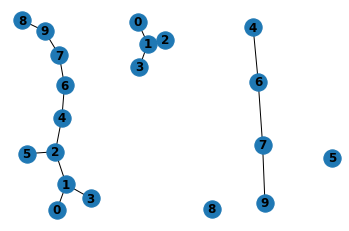

In [15]:
# baseline case: all_overlap with all nodes inside the cluster calculated
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_baseline_all_overlapping_clustering()
check_clustering(clustering_machine)
gcn_trainer_overlap = ClusterGCNTrainer_baseline(clustering_machine, 2, 2, input_layers = [])
gcn_trainer_overlap.train(1)
gcn_trainer_overlap.validate()

#### mini batch train nodes only of all_overlap case

<font color=orange>
Note: the all_overlap and train_overlap are the same effects in the train process
    
These two differ in the validation part. Train_overlap will lose some overalpping in the validation nodes which affect F1 score

In [16]:
# mini-batch of the all_overlap
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_all_overlapping_clustering()
clustering_machine.mini_batch_train_clustering()
# check_clustering(clustering_machine, True)
gcn_trainer_overlap = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [])
gcn_trainer_overlap.train(1)
gcn_trainer_overlap.validate()

0.5

#### mini batch train nodes only of train_overlap case

In [17]:
# mini-batch of the train_overlap
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_train_overlapping_clustering() 
clustering_machine.mini_batch_train_clustering()
# check_clustering(clustering_machine, True)
gcn_trainer_train_overlap = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [])
gcn_trainer_train_overlap.train(1)
gcn_trainer_train_overlap.validate()

0.25

#### mini-batch train nodes only in the isolated cluster

In [18]:
# mini-batch of the isolate
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_isolate_clustering() 
clustering_machine.mini_batch_train_clustering()
# check_clustering(clustering_machine, True)
gcn_trainer_isolate = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [])
gcn_trainer_isolate.train(1)
gcn_trainer_isolate.validate()

0.5

#### Default whole graph (recombine train nodes)

In [19]:
# default brute force case: recombination whole graph
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_baseline_all_overlapping_clustering()

gcn_trainer_whole = wholeClusterGCNTrainer_sequence(clustering_machine, 2, 2, input_layers = [])
gcn_trainer_whole.train(1)
gcn_trainer_isolate.validate()

0.5

#### base isolate: GCN calculated on the whole isolated cluster nodes

In [20]:
# whole isolate cluster of the baseline isolate
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_base_isolate_clustering() 
# check_clustering(clustering_machine, True)
gcn_trainer_base_isolate = ClusterGCNTrainer_baseline(clustering_machine, 2, 2, input_layers = [])
gcn_trainer_base_isolate.train(1)
gcn_trainer_base_isolate.validate()

0.5

### Use library data to check the results


In [21]:
def set_clustering_machine(data, partition_num = 10, test_ratio = 0.05, validation_ratio = 0.75):
    connect_edge_index, connect_features, connect_label = filter_out_isolate(data.edge_index, data.x, data.y)
    clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label, partition_num = partition_num)
    clustering_machine.decompose(test_ratio, validation_ratio)
    return clustering_machine

### Formal Test

In [22]:
def No_partition_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [32, 16], epochs=300):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    clustering_machine = copy.deepcopy(local_clustering_machine)
    clustering_machine.general_baseline_all_overlapping_clustering()
    # 0) train the data as a whole with no parition
    gcn_trainer = wholeClusterGCNTrainer_sequence(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer)
    gcn_trainer.train(epochs)
    
    test_F1 = gcn_trainer.test()
    validation_F1 = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    return test_F1, validation_F1, time_train_total, gcn_trainer

def Cluster_baseline_all_overlapping_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [32, 16], epochs=300):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    # use a dict to record 1.no partition 2. isolate clustering 3. train node overlapping clustering 4. all node overlapping clustering
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # 3) train all nodes overlapping clustering
    clustering_machine.general_baseline_all_overlapping_clustering()
    
    # training process:
    gcn_trainer = ClusterGCNTrainer_baseline(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer)
    gcn_trainer.train(epochs)
    
    test_F1 = gcn_trainer.test()
    validation_F1 = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    return test_F1, validation_F1, time_train_total, gcn_trainer

def Cluster_all_overlapping_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [32, 16], epochs=300):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    # use a dict to record 1.no partition 2. isolate clustering 3. train node overlapping clustering 4. all node overlapping clustering
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # 3) train all nodes overlapping clustering
    clustering_machine.general_all_overlapping_clustering()
    clustering_machine.mini_batch_train_clustering()
    gcn_trainer = ClusterGCNTrainer_mini_Train(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer)
    gcn_trainer.train(epochs)
    
#     trainer_drawer = draw_trainer_info(data_name, gcn_trainer, image_path, 'isolate_clustering')
#     trainer_drawer.draw_ave_loss_per_node()
    test_F1 = gcn_trainer.test()
    validation_F1 = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    return test_F1, validation_F1, time_train_total, gcn_trainer


def Isolate_clustering_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [32, 16], epochs=300):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    # use a dict to record 1.no partition 2. isolate clustering 3. train node overlapping clustering 4. all node overlapping clustering
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # 1) train the isolated clustering
    clustering_machine.general_isolate_clustering()
    clustering_machine.mini_batch_train_clustering()
    gcn_trainer = ClusterGCNTrainer_mini_Train(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer)
    gcn_trainer.train(epochs)
    
#     trainer_drawer = draw_trainer_info(data_name, gcn_trainer, image_path, 'isolate_clustering')
#     trainer_drawer.draw_ave_loss_per_node()
    test_F1 = gcn_trainer.test()
    validation_F1 = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    return test_F1, validation_F1, time_train_total, gcn_trainer

def Train_overlapping_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [32, 16], epochs=300):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    # use a dict to record 1.no partition 2. isolate clustering 3. train node overlapping clustering 4. all node overlapping clustering
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # 2) train the train node overlapping clustering
    clustering_machine.general_train_overlapping_clustering()
    clustering_machine.mini_batch_train_clustering()
    gcn_trainer = ClusterGCNTrainer_mini_Train(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer)
    gcn_trainer.train(epochs)
    
#     trainer_drawer = draw_trainer_info(data_name, gcn_trainer, image_path, 'isolate_clustering')
#     trainer_drawer.draw_ave_loss_per_node()
    test_F1 = gcn_trainer.test()
    validation_F1 = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    return test_F1, validation_F1, time_train_total, gcn_trainer

def Isolate_base_clustering_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [32, 16], epochs=300):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    # use a dict to record 1.no partition 2. isolate clustering 3. train node overlapping clustering 4. all node overlapping clustering
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # 1) train the isolated clustering
    clustering_machine.general_base_isolate_clustering()
    gcn_trainer = ClusterGCNTrainer_baseline(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer)
    gcn_trainer.train(epochs)
    
#     trainer_drawer = draw_trainer_info(data_name, gcn_trainer, image_path, 'isolate_clustering')
#     trainer_drawer.draw_ave_loss_per_node()
    test_F1 = gcn_trainer.test()
    validation_F1 = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    return test_F1, validation_F1, time_train_total, gcn_trainer

In [23]:
def check_train_loss_converge(clustering_machine, data_name, dataset, image_path,  comments, input_layer = [32, 16]):
    t0, v0, time0, baseline_overlap_trainer = Cluster_baseline_all_overlapping_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
    draw_baseline_Cluster_all_overlapping = draw_trainer_info(data_name, baseline_overlap_trainer, image_path, 'baseline_overlap_' + comments)
    draw_baseline_Cluster_all_overlapping.draw_ave_loss_per_node()
    
    t1, v1, time1, Isolate_clustering_trainer = Isolate_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
    draw_Isolate_clustering = draw_trainer_info(data_name, Isolate_clustering_trainer, image_path, 'Isolate_' + comments)
    draw_Isolate_clustering.draw_ave_loss_per_node()
    
    t2, v2, time2, Cluster_all_overlapping_trainer = Cluster_all_overlapping_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
    draw_Cluster_all_overlapping = draw_trainer_info(data_name, Cluster_all_overlapping_trainer, image_path, 'train_batch_' + comments)
    draw_Cluster_all_overlapping.draw_ave_loss_per_node()
    
    t3, v3, time3, No_partition_trainer = No_partition_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
    draw_No_partition = draw_trainer_info(data_name, No_partition_trainer, image_path, 'recombine_' + comments)
    draw_No_partition.draw_ave_loss_per_node()
    
    t4, v4, time4, Isolate_base_clustering_trainer = Isolate_base_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
    draw_base_Isolate_clustering = draw_trainer_info(data_name, Isolate_base_clustering_trainer, image_path, 'Isolate_base_' + comments)
    draw_base_Isolate_clustering.draw_ave_loss_per_node()

In [ ]:
''' Draw the information about the GCN calculating batch size '''
def draw_cluster_info(clustering_machine, data_name, dataset, img_path, comment):
    cluster_id = clustering_machine.clusters    # a list of cluster indices
    cluster_datapoints = {'cluster_id': cluster_id,  \
                          'overlapping' : [clustering_machine.info_overlapping_cluster_size[idx] for idx in cluster_id], \
                          'isolate' : [clustering_machine.info_isolate_cluster_size[idx] for idx in cluster_id], \
                          'train' : [clustering_machine.info_train_cluster_size[idx] for idx in cluster_id], \
                          'test' : [clustering_machine.info_test_cluster_size[idx] for idx in cluster_id], \
                          'validation' : [clustering_machine.info_validation_cluster_size[idx] for idx in cluster_id]
                         }
                         
    df = pd.DataFrame(data=cluster_datapoints, dtype=np.int32)
    # print(df)
    df_reshape = df.melt('cluster_id', var_name = 'clusters', value_name = 'node_num')
    
    # print(newdf)
    sns.set(style='whitegrid')
    g = sns.catplot(x="cluster_id", y="node_num", hue='clusters', kind='bar', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' cluster node distribution')
    g.set_xlabels("Cluster ID")
    g.set_ylabels("Number of nodes")
    g.savefig(image_path+data_name+'_cluster_node_distr', bbox_inches='tight')

In [24]:
''' Execute the testing program '''
def execute_one(clustering_machine, image_path, repeate_time = 5, input_layer = [32, 16]):
    """
    return all test-F1 and validation-F1 for all four models
    """
    test_f1 = {}
    validation_f1 = {}
    time_total_train = {}
    for i in range(repeate_time):
        t0, v0, time0, _ = Cluster_baseline_all_overlapping_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
        t1, v1, time1, _ = Isolate_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
        t2, v2, time2, _ = Cluster_all_overlapping_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
        t3, v3, time3, _ = No_partition_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
#         t4, v4, time4, _ = Isolate_base_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=2000)
        
        test_f1[i] = [t0, t1, t2, t3]
        validation_f1[i] = [v0, v1, v2, v3]
        time_total_train[i] = [time0, time1, time2, time3]
    return test_f1, validation_f1, time_total_train

def store_data_multi_tests(f1_data, data_name, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id,  \
                'baseline_overlap' : [f1_data[key][0] for key in run_id], \
                'isolate' : [f1_data[key][1] for key in run_id], \
                'train_batch' : [f1_data[key][2] for key in run_id], \
                'recombine_whole_graph' : [f1_data[key][3] for key in run_id], \
                }
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels("models")
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')

### Use data from pytorch geometric datasets

In [25]:
test_folder_name = 'Onehop_Net/'

### PubMed dataset

In [ ]:
# this data is also used the in the trivial example of the cluster-GCN paper
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root='~/tmp/Planetoid/PubMed', name=data_name)
# print('\n Number of data inside the dataset: ', len(dataset) )
# print_data_info(dataset)
data = dataset[0]

image_data_path = './results/' + data_name + '/' + test_folder_name
partition_nums = [2, 5, 10]

In [ ]:
# check convergence
for partn in partition_nums:
    clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.75)
    print('Start checking train loss for partition num: ' + str(partn))
    img_path = image_data_path + 'cluster_num_' + str(partn) + '/'
    check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = [])

In [ ]:
for partn in partition_nums:
    clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.75)
    print('Start running for partition num: ' + str(partn))
    img_path = image_data_path + 'cluster_num_' + str(partn) + '/'
    test_f1, validation_f1, time_total_train = execute_one(clustering_machine, img_path, repeate_time = 10, input_layer = [])
    validation_res = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn))
    draw_data_multi_tests(validation_res, data_name, 'validation_cluster_num_' + str(partn), 'F1 score')
    test_res = store_data_multi_tests(test_f1, data_name, img_path, 'test_cluster_num_' + str(partn))
    draw_data_multi_tests(test_res, data_name, 'test_cluster_num_' + str(partn), 'F1 score')
    time_res = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn))
    draw_data_multi_tests(time_res, data_name, 'train_time_cluster_num_' + str(partn), 'Train Time (ms)')


### Cora dataset

In [26]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root='~/tmp/Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
partition_nums = [2, 5, 10]


Start checking train loss for partition num: 2
Start checking train loss for partition num: 5
Start checking train loss for partition num: 10


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

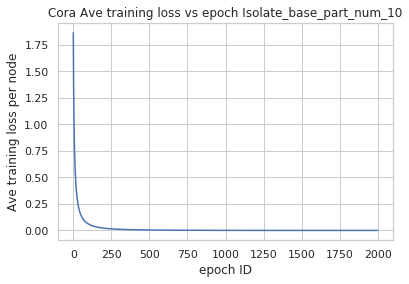

In [27]:
# check convergence
for partn in partition_nums:
    clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.75)
    print('Start checking train loss for partition num: ' + str(partn))
    img_path = image_data_path + 'cluster_num_' + str(partn) + '/'
    check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = [])

Start running for partition num: 2
Start running for partition num: 5
Start running for partition num: 10


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

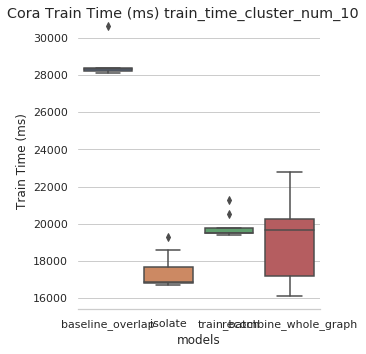

In [28]:
for partn in partition_nums:
    clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.75)
    print('Start running for partition num: ' + str(partn))
    img_path = image_data_path + 'cluster_num_' + str(partn) + '/'
    test_f1, validation_f1, time_total_train = execute_one(clustering_machine, img_path, repeate_time = 10, input_layer = [])
    validation_res = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn))
    draw_data_multi_tests(validation_res, data_name, 'validation_cluster_num_' + str(partn), 'F1 score')
    test_res = store_data_multi_tests(test_f1, data_name, img_path, 'test_cluster_num_' + str(partn))
    draw_data_multi_tests(test_res, data_name, 'test_cluster_num_' + str(partn), 'F1 score')
    time_res = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn))
    draw_data_multi_tests(time_res, data_name, 'train_time_cluster_num_' + str(partn), 'Train Time (ms)')

### CiteSeer Dataset

In [29]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root='~/tmp/Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
partition_nums = [2, 5, 10]



Start checking train loss for partition num: 2
Start checking train loss for partition num: 5
Start checking train loss for partition num: 10


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

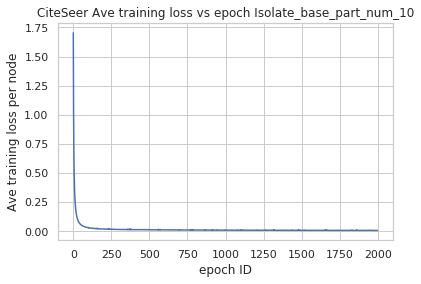

In [30]:
# check convergence
for partn in partition_nums:
    clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.75)
    print('Start checking train loss for partition num: ' + str(partn))
    img_path = image_data_path + 'cluster_num_' + str(partn) + '/'
    check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = [])

Start running for partition num: 2
Start running for partition num: 5
Start running for partition num: 10


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

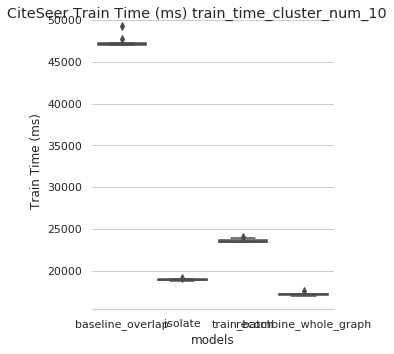

In [31]:
for partn in partition_nums:
    clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.75)
    print('Start running for partition num: ' + str(partn))
    img_path = image_data_path + 'cluster_num_' + str(partn) + '/'
    test_f1, validation_f1, time_total_train = execute_one(clustering_machine, img_path, repeate_time = 10, input_layer = [])
    validation_res = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn))
    draw_data_multi_tests(validation_res, data_name, 'validation_cluster_num_' + str(partn), 'F1 score')
    test_res = store_data_multi_tests(test_f1, data_name, img_path, 'test_cluster_num_' + str(partn))
    draw_data_multi_tests(test_res, data_name, 'test_cluster_num_' + str(partn), 'F1 score')
    time_res = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn))
    draw_data_multi_tests(time_res, data_name, 'train_time_cluster_num_' + str(partn), 'Train Time (ms)')

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)